# Wykrywanie naczyń dna oka

## Imports

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import ceil
from skimage import img_as_ubyte, morphology, exposure
from skimage.filters import unsharp_mask, sato, threshold_local
from skimage.measure import moments_central, moments_hu
from skimage.util import img_as_float
from statistics import variance
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score

## Constants

In [33]:
IMAGE1 = "Image_05L"
IMAGE2 = "Image_06L"
IMAGE3 = "Image_07L"
IMAGE4 = "Image_08L"
IMAGE5 = "Image_09L"

IMAGE1_PATH = "photos/{0}.jpg".format(IMAGE1)
IMAGE2_PATH = "photos/{0}.jpg".format(IMAGE2)
IMAGE3_PATH = "photos/{0}.jpg".format(IMAGE3)
IMAGE4_PATH = "photos/{0}.jpg".format(IMAGE4)
IMAGE5_PATH = "photos/{0}.jpg".format(IMAGE5)

IMAGE1_HOLD_OUT_PATH = "photos/{0}_1stHO.png".format(IMAGE1)
IMAGE2_HOLD_OUT_PATH = "photos/{0}_1stHO.png".format(IMAGE2)
IMAGE3_HOLD_OUT_PATH = "photos/{0}_1stHO.png".format(IMAGE3)
IMAGE4_HOLD_OUT_PATH = "photos/{0}_1stHO.png".format(IMAGE4)
IMAGE5_HOLD_OUT_PATH = "photos/{0}_1stHO.png".format(IMAGE5)

## Functions

In [34]:
def loadImage(file, size=400):
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    # img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [35]:
def showImages(img1, img2, img3, img4, img5):
    fig = plt.figure(figsize=(15, 20))
    plt.subplot(3, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.title('Original')

    plt.subplot(3, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    plt.title('Prepared')

    plt.subplot(3, 2, 3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')
    plt.title('Binary')

    plt.subplot(3, 2, 4)
    plt.imshow(img4, cmap='gray')
    plt.axis('off')
    plt.title('Hold Out')

    plt.subplot(3, 2, 5)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.title('Original')

    plt.subplot(3, 2, 6)
    plt.imshow(img5, cmap='gray')
    plt.axis('off')
    plt.title('Visualization')

In [36]:
def preProcessing(img, optionNumbers):
    for num in optionNumbers:
        if num == 0:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        elif num == 1:
            img = img_as_ubyte(unsharp_mask(img, radius=5, amount=2))

        elif num == 2:
            kernel_sharpening = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
            img = cv2.filter2D(img, -1, kernel_sharpening)

        elif num == 3:
            img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        elif num == 4:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)

        elif num == 5:
            invGamma = 0.75
            table = np.array([((i / 255.0) ** invGamma) * 255
                for i in np.arange(0, 256)]).astype(np.uint8)
            img = cv2.LUT(img, table)

        elif num == 6:
            nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(img), connectivity=8)
            sizes = stats[1:, -1]; nb_components = nb_components - 1
            min_size = 600
            img = np.zeros((output.shape))
            for i in range(0, nb_components):
                if sizes[i] >= min_size:
                    img[output == i + 1] = 1

        elif num == 7:
            img = img_as_ubyte(exposure.equalize_adapthist(img, clip_limit=0.01))

        elif num == 8:
            img = cv2.dilate(img, np.ones((1,1), np.uint8), iterations=1)

        elif num == 9:
            img = cv2.erode(img, np.ones((2,2), np.uint8), iterations=1)

    return img

In [37]:
def properProcessing(img):
    img = sato(img)
    return img_as_ubyte(img)

In [38]:
def removeBorder(original, img):
    for i in range(len(original)):
        for j in range(len(original[0])):
            if original[i][j] < 50:
                img[i][j] = 0
    return img 

def lighten(img):
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] > 75:
                if img[i][j] <= 250:
                    img[i][j] += 5
            else:
                if img[i][j] < 76:
                    if img[i][j] > 5:
                        img[i][j] -= 5

    return img 

In [39]:
def applyBinary(bin, org):
    ori = np.copy(org)
    for i in range(len(bin)):
        for j in range(len(bin[0])):
            if bin[i][j] > 0:
                ori[i][j] = 255

    return ori

In [40]:
def checkEffectivity(img, ho):
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i, j] == 1 and ho[i, j] == 1:
                TP += 1
            elif img[i, j] == 0 and ho[i, j] == 0:
                TN += 1
            elif img[i, j] == 0 and ho[i, j] == 1:
                FP += 1
            elif img[i, j] == 1 and ho[i, j] == 0:
                FN += 1

    sen = round(TP / (TP + FN), 4)
    spe = round(TN / (TN + FP), 4)
    acc = round((TP + TN) / (TP + FP + TN + FN), 4)
    avg = round((sen + spe) / 2, 4)

    print('Macierz pomylek:\n{} TP\n{} FP\n{} FN\n{} TN\n'.format(TP, FP, FN, TN))
    print('Sensitivity: {}%'.format(round(sen * 100, 2)))
    print('Specificity: {}%'.format(round(spe * 100, 2)))
    print('Accuracy: {}%'.format(round(acc * 100, 2)))
    print('Specificity&Sensitivity Average: {}%'.format(round(avg * 100, 2)))
    return [TP, TN, FP, FN, sen, spe, acc, avg]

In [41]:
def getPreparedImage(img):
    preparedImage = preProcessing(img, [0, 1, 7, 5, 9])
    preparedImage = lighten(preparedImage)
    return preparedImage

In [42]:
def getResultImage(img):
    resultImage = properProcessing(img)
    resultImage = preProcessing(resultImage, [1, 8, 3])
    return resultImage

In [43]:
def getResultBinary(img, prepImg):
    resultBinary = preProcessing(img > 30, [6]).astype(int)
    resultBinary = removeBorder(prepImg, resultBinary)
    return resultBinary

In [44]:
def getHoldOut(path):
    holdOut = (preProcessing(loadImage(path), [0]) / 255).astype(int)
    return holdOut

## Main

Macierz pomylek:
51604 TP
24337 FP
13769 FN
869330 TN

Sensitivity: 78.94%
Specificity: 97.28%
Accuracy: 96.03%
Specificity&Sensitivity Average: 88.11%


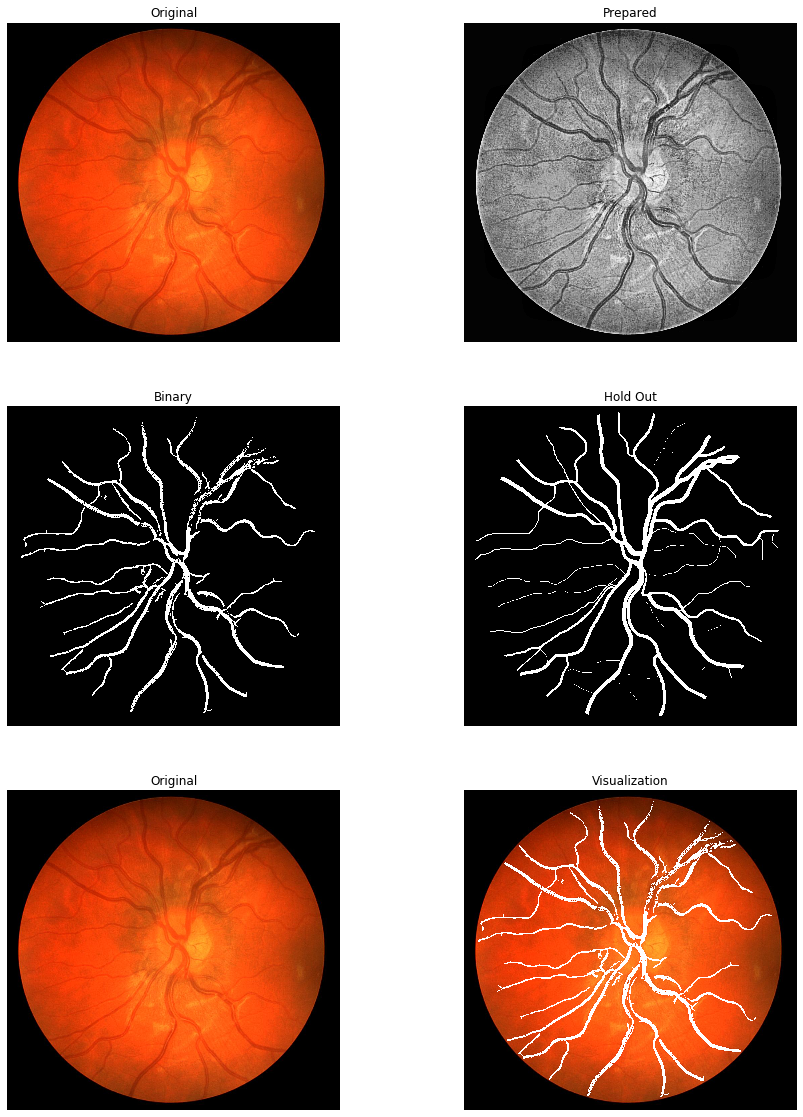

In [45]:
originalImage = loadImage(IMAGE1_PATH)
preparedImage = getPreparedImage(originalImage)
resultImage = getResultImage(preparedImage)
resultBinary = getResultBinary(resultImage, preparedImage)
holdOut = getHoldOut(IMAGE1_HOLD_OUT_PATH)

visualized = applyBinary(resultBinary, originalImage)

showImages(originalImage, preparedImage, resultBinary, holdOut, visualized)
_ = checkEffectivity(resultBinary, holdOut)

## 5.0

In [46]:
class Segment:
    def __init__(self, img, holdOut):
        self.img = img_as_float(img)
        self.colorVariance = variance(self.img.flatten())
        self.centralMoments = moments_central(self.img)
        self.huMoments = moments_hu(self.img)
        self.isVesselBin = holdOut[ceil(len(holdOut) / 2)][ceil(len(holdOut) / 2)]

    def __repr__(self):
        return str([self.colorVariance]) + "\n" + str(self.centralMoments.flatten()) + "\n" + str(self.huMoments) + "\n" + str(self.isVesselBin)

    def getData(self):
        return [*[self.colorVariance], *self.centralMoments.flatten(), *self.huMoments]

In [47]:
def imageSplitting(img, holdOut):
    segments = []
    for i in range(0, len(img), 5):
        for j in range(0, len(img[0]), 5):
            segments.append(Segment(img[i : i + 5, j : j + 5], holdOut[i : i + 5, j : j + 5]))

    return segments

In [48]:
def prepareData(img, holdOut):
    segments = imageSplitting(img, holdOut)
    data = []
    target = []
    for segment in segments:
        data.append(segment.getData())
        target.append(segment.isVesselBin)
    
    return np.array(data).astype(np.uint8), np.array(target).astype(np.uint8)

In [49]:
def show50(img1, img2, img3):
    fig = plt.figure(figsize=(15, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.title('Test image')

    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    plt.title('Predicted')

    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')
    plt.title('HoldOut')

In [50]:
data, target = prepareData(preparedImage, holdOut)
decisionTree = DecisionTreeClassifier(criterion = 'entropy')

In [51]:
accuracy_model = []
for train_index, test_index in KFold(n_splits=5, shuffle=False).split(data):
    X_train, X_test = list(map(data.__getitem__, train_index)), list(map(data.__getitem__, test_index))
    y_train, y_test = list(map(target.__getitem__, train_index)), list(map(target.__getitem__, test_index))
                
    model = decisionTree.fit(X_train, y_train)
    accuracy_model.append(round(accuracy_score(y_test, model.predict(X_test), normalize=True) * 100, 3))

print('Accuracy score: {}'.format(accuracy_model))
print('Cross-validated score: {}'.format(np.round(cross_val_score(model, data, target) * 100, 3)))
print('Score: {}'.format(round(decisionTree.score(X_test, y_test) * 100, 3)))

Accuracy score: [86.979, 87.148, 88.685, 91.029, 94.049]
Cross-validated score: [86.354 89.701 88.398 91.471 92.656]
Score: 94.049


In [52]:
originalImageTest = loadImage(IMAGE3_PATH)
preparedImageTest = getPreparedImage(originalImageTest)
resultImageTest = getResultImage(preparedImageTest)
resultBinaryTest = getResultBinary(resultImageTest, preparedImageTest)
holdOutTest = getHoldOut(IMAGE3_HOLD_OUT_PATH)

data_test, target_test = prepareData(preparedImageTest, holdOutTest)

In [53]:
decisionTree.fit(data, target)
predicted = decisionTree.predict(data_test)

Macierz pomylek:
579 TP
2509 FP
4447 FN
30865 TN

Sensitivity: 11.52%
Specificity: 92.48%
Accuracy: 81.89%
Specificity&Sensitivity Average: 52.0%


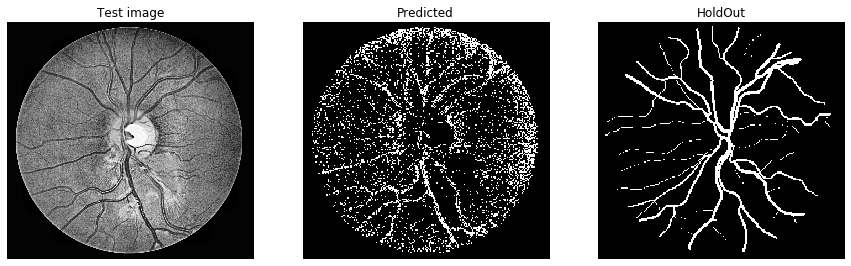

In [54]:
show50(preparedImageTest, predicted.reshape(192, 200), target.reshape(192, 200))
_ = checkEffectivity(predicted.reshape(192, 200), target.reshape(192, 200))